In [1]:
import os, sys
import h5py as h5
import numpy as np
import tifffile as tf

import caiman as cm
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.source_extraction import cnmf

2021-07-31 08:33:53.484527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64:
2021-07-31 08:33:53.484558: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
base = "/media/carmichael/LaCie SSD/JR/data/ca_imaging/28.06.21/slice4/"
name = "1-40X-loc1.h5"
path=base+name

loc="mc/ast"

if base[-1] != os.sep:
    base += os.sep

# smaller version
out = "testing.h5"
y, x = 644, 362
w, h = 180, 180

with h5.File(path, "r") as orig:
    with h5.File(base+out, "w") as new:

        Z, _, _ = orig[loc].shape
        cp = new.create_dataset(loc, shape=(Z, w, h), dtype="i2")
        new.create_dataset("dummy", shape=(1, 1, 1), dtype="i2")
        cp[:, :, :] = orig[loc][:, x:x+w, y:y+h]
    
path=base+out
print(path,"\n", repr(loc))



/media/carmichael/LaCie SSD/JR/data/ca_imaging/28.06.21/slice4/testing.h5 
 'mc/ast'


In [3]:
# start the cluster
try:
    cm.stop_server()  # stop it if it was running
except():
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local',
                                                 n_processes=6,  # TODO change to None
                                                 single_thread=False)

/home/carmichael/anaconda3/envs/caiman/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/carmichael/anaconda3/envs/caiman/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/carmichael/.local/lib/python3.7/site-packages/scipy/sparse/dia.py:342: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dty

In [4]:
# load images
#TODO
images = None
dims = None
bord_px = 0     # because border_nan == 'copy' in motion correction

# with h5.File(path, "r") as file:
#     data = file[loc]
#     dims = data.shape

fname_new = cm.save_memmap([path], base_name='memmap_', var_name_hdf5=loc,
                           order='C', border_to_0=0, dview=dview)

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

(200, 180, 180)


In [5]:
# %% Parameters for source extraction and deconvolution (CNMF-E algorithm)

p = 1  # order of the autoregressive system
K = None  # upper bound on number of components per patch, in general None for 1p data
gSig = (3, 3)  # gaussian width of a 2D gaussian kernel, which approximates a neuron # 3, 3
gSiz = (13, 13)  # average diameter of a neuron, in general 4*gSig+1  # 13, 13
Ain = None  # possibility to seed with predetermined binary masks
merge_thr = .7  # merging threshold, max correlation allowed
rf = 40  # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20  # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 2  # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1  # downsampling factor in space for initialization,
#                     increase if you have memory problems
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                     True performs global low-rank approximation if gnb>0
gnb = 0  # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb= 0: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb<-1: Don't return background
nb_patch = 0  # number of background components (rank) per patch if gnb>0,
#                     else it is set automatically
min_corr = .8  # min peak value from correlation image # .8
min_pnr = 10  # min peak to noise ration from PNR image # 10
ssub_B = 2  # additional downsampling factor in space for background # 2
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor #1.4

opts = params.CNMFParams(params_dict={'dims': dims,
                                'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                'merge_thr': merge_thr,
                                'p': p,
                                'tsub': tsub,
                                'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,  # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                'method_deconvolution': 'oasis',  # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                'update_background_components': True,
                                # sometimes setting to False improve the results
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'normalize_init': False,  # just leave as is
                                'center_psf': True,  # leave as is for 1 photon
                                'ssub_B': ssub_B,
                                'ring_size_factor': ring_size_factor,
                                'del_duplicates': True,  # whether to remove duplicates from initialization
                                'border_pix': bord_px})  # number of pixels to not consider in the borders)

In [6]:
# %% compute some summary images (correlation and peak to noise)
# change swap dim if output looks weird, it is a problem with tiffile
cn_filter, pnr = cm.summary_images.correlation_pnr(images[::1], gSig=gSig[0], swap_dim=False)
# if your images file is too long this computation will take unnecessarily
# long time and consume a lot of memory. Consider changing images[::1] to
# images[::5] or something similar to compute on a subset of the data

0.8
10


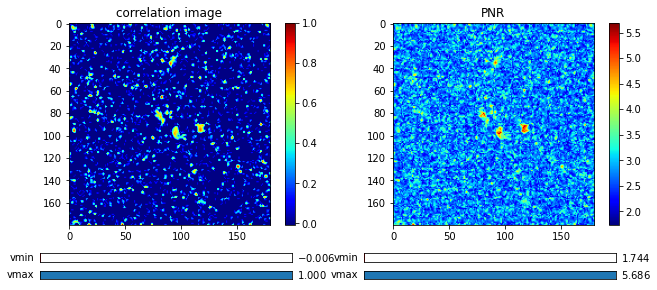

In [7]:
# inspect the summary images and set the parameters
inspect_correlation_pnr(cn_filter, pnr)
# print parameters set above, modify them if necessary based on summary images
print(min_corr)  # min correlation of peak (from correlation image)
print(min_pnr)  # min peak to noise ratio

In [8]:
# %% RUN CNMF ON PATCHES
cnm = cnmf.CNMF(n_processes=n_processes, dview=dview, Ain=Ain, params=opts)
cnm.fit(images)

/home/carmichael/anaconda3/envs/caiman/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [9]:
# # %% DISCARD LOW QUALITY COMPONENTS
# min_SNR = 2.5  # adaptive way to set threshold on the transient size #2.5
# r_values_min = 0.85  # threshold on space consistency (if you lower more components
# #                        will be accepted, potentially with worst quality)
# cnm.params.set('quality', {'min_SNR': min_SNR,
#                            'rval_thr': r_values_min,
#                            'use_cnn': False})
# cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

# print(' ***** ')
# print('Number of total components: ', len(cnm.estimates.C))
# print('Number of accepted components: ', len(cnm.estimates.idx_components))

# # %% PLOT COMPONENTS
# cnm.dims = dims
# display_images = True  # Set to true to show movies and images
# if display_images:
#     cnm.estimates.plot_contours(img=cn_filter, idx=cnm.estimates.idx_components)
#     cnm.estimates.view_components(images, idx=cnm.estimates.idx_components)

In [23]:
mov = None
mov = cnm.estimates.play_movie(images, q_max=99.5, magnification=0.25,
                                 include_bck=True, gain_res=10, bpx=bord_px,display=False, use_color=False)

with h5.File("/media/carmichael/LaCie SSD/JR/data/ca_imaging/28.06.21/slice1/out.h5", "w") as file:
    data = file.create_dataset("cnmfe/neu", dtype="i2", shape=mov.shape)
    data[:, :, :] = mov

tf.imsave("/media/carmichael/LaCie SSD/JR/data/ca_imaging/28.06.21/slice4/out.tiff", mov)
    
print("saved")

saved


In [40]:
from caiman.source_extraction.cnmf.initialization import downscale

def get_reconstructed(cnmfe, imgs, include_bck=True):

    dims = imgs.shape[1:]

    AC = cnmfe.A.dot(cnmfe.C)
    Y_rec = AC.reshape(dims + (-1,), order='F')
    Y_rec = Y_rec.transpose([2, 0, 1])
    if cnmfe.W is not None:
        ssub_B = int(round(np.sqrt(np.prod(dims) / cnmfe.W.shape[0])))
        B = imgs.reshape((-1, np.prod(dims)), order='F').T - AC
        if ssub_B == 1:
            B = cnmfe.b0[:, None] + cnmfe.W.dot(B - cnmfe.b0[:, None])
        else:
            WB = cnmfe.W.dot(downscale(B.reshape(dims + (B.shape[-1],), order='F'),
                                      (ssub_B, ssub_B, 1)).reshape((-1, B.shape[-1]), order='F'))
            Wb0 = cnmfe.W.dot(downscale(cnmfe.b0.reshape(dims, order='F'),
                                       (ssub_B, ssub_B)).reshape((-1, 1), order='F'))
            B = cnmfe.b0.flatten('F')[:, None] + (np.repeat(
                np.repeat((WB - Wb0).reshape(((dims[0] - 1) // ssub_B + 1, (dims[1] - 1) // ssub_B + 1, -1), order='F'),
                          ssub_B, 0), ssub_B, 1)[:dims[0], :dims[1]].reshape((-1, B.shape[-1]), order='F'))
        B = B.reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    elif cnmfe.b is not None and self.f is not None:
        B = cnmfe.b.dot(self.f)
        if 'matrix' in str(type(B)):
            B = B.toarray()
        B = B.reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    else:
        B = np.zeros_like(Y_rec)

    reconstructed = Y_rec + include_bck * B
    return reconstructed

rec = get_reconstructed(cnm.estimates, images)

In [41]:
tf.imsave("/media/carmichael/LaCie SSD/JR/data/ca_imaging/28.06.21/slice4/rec.tiff", rec)

In [29]:
mov_dff1, _ = (mov+abs(np.min(mov))+1).computeDFF(secsWindow=5, method='delta_f_over_sqrt_f')
tf.imsave("/media/carmichael/LaCie SSD/JR/data/ca_imaging/28.06.21/slice4/out_dff1.tiff", mov_dff1)
# tf.imsave("/media/carmichael/LaCie SSD/JR/data/ca_imaging/28.06.21/slice4/out_dff2.tiff", mov_dff1)

In [ ]:
# stop cluster
cm.stop_server()